# TOA radiation evaluation for nextGEMS cycle 3

contributed by Sebastian Milinski (sebastian.milinski@ecmwf.int), based on [STARTHERE_IFS.ipynb](./STARTHERE_IFS.ipynb)

- Includes basic metrics for top-of-atmosphere (TOA) radiation and surface temperature.
- global mean and regional
- reference datasets: CERES (radiation), ERA5 (temperature)

Use the kernel Python 3 (based on the module python3/unstable)

If you get an error with `import gribscan` below, run the following in a cell, then restart the kernel:
`%pip install gribscan`


In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib.cm as cm
import cmocean.cm as cmo
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import gribscan
import intake
# Import Cdo-py
import cdo
cdo = cdo.Cdo(tempdir='/scratch/m/m300265/tmp/cdo-py') #change the tempdir to your scratch

import cartopy.crs as ccrs
import calendar # convert month numbers into month name strings with calendar.month_name[1] => 'January'
# all-caps month abbr: calendar.month_abbr[1].upper() => 'JAN'
import os

plotdir = './plots/radiation/'
if not os.path.exists(plotdir):
    os.makedirs(plotdir)


ERROR 1: PROJ: proj_create_from_database: Open of /sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/share/proj failed


In [2]:
def attach_coords(ds):
    model_lon = ds.lon.values
    model_lat = ds.lat.values
    return ds.assign_coords(
        lat = (("value",), model_lat, {"units": "degree_north"}),
        lon = (("value",), model_lon, {"units": "degree_east"}),
    )

In [3]:
def convert_to_xarray(ds,var,grid='025'):
    # select a variable, reshape lat lon and convert to XArray DataArray
    # needs to specify an existing varname e.g. '2t'
    # assumes that ds has the shape time | value
    
    # arrange value coordinate into lat/lon
    sample = np.reshape(ds[var].values, newshape=(len(ds.time),len(np.unique(ds.lat)),len(np.unique(ds.lon))))
    
    # create DataArray with proper name, dimensions, and coordinates
    da = xr.DataArray(
        data=sample,
        name=var,
        dims=["time", "lat", "lon"],
        coords=dict(
            time=ds.time.data,
            lon=(["lon"], np.unique(ds.lon)),
            # lat=(["lat"], np.unique(ds.lat)),
            lat=(["lat"], np.unique(ds.lat)[::-1]), # use this because otherwise lats are flipped; only comment for testing
        ),
        attrs=dict(
            # variable=var,
        ),
    )
    
    # attach griddes so that cdo interprets it as a regular lonlat grid:
    if grid=='025':
        my_griddes = '/work/bm1235/ifs-grids/multio_grids_cdoPython/025_griddes'
    elif grid=='1':
        my_griddes = '/work/bm1235/ifs-grids/multio_grids_cdoPython/1_griddes'
    else:
        raise Exception("Unsupported grid. Maybe new grid introduced in multIO?")
        
    da = cdo.setgrid(my_griddes, input=da.to_dataset(), returnXDataset=True)[var]
    
    return da

## load model output
Open catalog:

### IFS

In [4]:
cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")

In [5]:
# which IFS experiments are available? Which streams are in the IFS catalog for experiment 'tco2559-ng5-cycle3'?
print(list(cat.IFS))
print(list(cat.IFS['IFS_4.4-FESOM_5-cycle3'])) 

['IFS_4.4-FESOM_5-cycle3', 'IFS_9-NEMO_25-cycle3', 'IFS_28-NEMO_25-cycle3', 'IFS_grids']
['2D_1h_native', '3D_1h6h_native', '2D_monthly_0.25deg', '3D_monthly_0.25deg', '2D_monthly_1deg', '3D_monthly_1deg', 'WAM_1h_native']


TOA and surface fields are in the 2D output. We load the 0.25 deg because we don't need higher resolution for comparing to observations.

In [6]:
ds = cat.IFS['IFS_4.4-FESOM_5-cycle3']['2D_monthly_1deg'].to_dask()
ds_9km = cat.IFS['IFS_9-NEMO_25-cycle3']['2D_monthly_1deg'].to_dask()
ds_28km = cat.IFS['IFS_28-NEMO_25-cycle3']['2D_monthly_1deg'].to_dask()

In [7]:
# get ttr, tsr, 2t and reshape to (#lat x #lon) numpy array
ifs_2t = convert_to_xarray(ds,var='2t',grid='1')   # 2t is needed for the gregory plot
ifs_sst = convert_to_xarray(ds,var='sst',grid='1') # sst is only used for the quick map below, feel free to remove
ifs_ttr = convert_to_xarray(ds,var='ttr',grid='1')
ifs_tsr = convert_to_xarray(ds,var='tsr',grid='1')

In [8]:
# same for 9km
# get ttr, tsr, 2t and reshape to (#lat x #lon) numpy array
ifs_9km_2t = convert_to_xarray(ds_9km,var='2t',grid='1')   # 2t is needed for the gregory plot
ifs_9km_sst = convert_to_xarray(ds_9km,var='sst',grid='1') # sst is only used for the quick map below, feel free to remove
ifs_9km_ttr = convert_to_xarray(ds_9km,var='ttr',grid='1')
ifs_9km_tsr = convert_to_xarray(ds_9km,var='tsr',grid='1')

In [9]:
# same for 28km
# get ttr, tsr, 2t and reshape to (#lat x #lon) numpy array
ifs_28km_2t = convert_to_xarray(ds_28km,var='2t',grid='1')   # 2t is needed for the gregory plot
ifs_28km_sst = convert_to_xarray(ds_28km,var='sst',grid='1') # sst is only used for the quick map below, feel free to remove
ifs_28km_ttr = convert_to_xarray(ds_28km,var='ttr',grid='1')
ifs_28km_tsr = convert_to_xarray(ds_28km,var='tsr',grid='1')

In [10]:
# combine all radiation vars into a dataset:
TOA_ifs = ifs_ttr.to_dataset()
TOA_ifs = TOA_ifs.assign(tsr=ifs_tsr)

# add net radiation
TOA_ifs = TOA_ifs.assign(tnr=TOA_ifs.tsr+TOA_ifs.ttr)

# compute global mean:
TOA_ifs_gm = cdo.fldmean(input=TOA_ifs, returnXDataset=True)

In [11]:
# same for 9km
# combine all radiation vars into a dataset:
TOA_ifs_9km = ifs_9km_ttr.to_dataset()
TOA_ifs_9km = TOA_ifs_9km.assign(tsr=ifs_9km_tsr)

# add net radiation
TOA_ifs_9km = TOA_ifs_9km.assign(tnr=TOA_ifs_9km.tsr+TOA_ifs_9km.ttr)

# compute global mean:
TOA_ifs_9km_gm = cdo.fldmean(input=TOA_ifs_9km, returnXDataset=True)

In [12]:
# same for 28km
# combine all radiation vars into a dataset:
TOA_ifs_28km = ifs_28km_ttr.to_dataset()
TOA_ifs_28km = TOA_ifs_28km.assign(tsr=ifs_28km_tsr)

# add net radiation
TOA_ifs_28km = TOA_ifs_28km.assign(tnr=TOA_ifs_28km.tsr+TOA_ifs_28km.ttr)

# compute global mean:
TOA_ifs_28km_gm = cdo.fldmean(input=TOA_ifs_28km, returnXDataset=True)

---

### ICON

In [13]:
ds_icon = cat.ICON['ngc3028'].to_dask()
ds_icon

<xarray.Dataset>
Dimensions:                              (time: 2010, depth_half: 129,
                                          cell: 12, level_full: 90, crs: 1,
                                          depth_full: 128,
                                          soil_depth_water_level: 5,
                                          level_half: 91,
                                          soil_depth_energy_level: 5)
Coordinates:
  * crs                                  (crs) float32 nan
  * depth_full                           (depth_full) float32 1.0 ... 5.904e+03
  * depth_half                           (depth_half) float32 0.0 ... 6.003e+03
  * level_full                           (level_full) int32 1 2 3 4 ... 88 89 90
  * level_half                           (level_half) int32 1 2 3 4 ... 89 90 91
  * soil_depth_energy_level              (soil_depth_energy_level) float32 0....
  * soil_depth_water_level               (soil_depth_water_level) float32 0.0...
  * time                                 (time) datetime64[ns] 2020-01-21 ......
Dimensions without coordinates: cell
Data variables: (12/88)
    a_tracer_v_to                        (time, depth_half, cell) float32 ...
    atmos_fluxes_frshflux_evaporation    (time, cell) float32 ...
    atmos_fluxes_frshflux_precipitation  (time, cell) float32 ...
    atmos_fluxes_frshflux_runoff         (time, cell) float32 ...
    atmos_fluxes_frshflux_snowfall       (time, cell) float32 ...
    atmos_fluxes_heatflux_latent         (time, cell) float32 ...
    ...                                   ...
    va                                   (time, level_full, cell) float32 ...
    vas                                  (time, cell) float32 ...
    w                                    (time, depth_half, cell) float32 ...
    wa_phy                               (time, level_half, cell) float32 ...
    wind_speed_10m                       (time, cell) float32 ...
    zos                                  (time, cell) float32 ...

In [14]:
icon_5km_2t_daily_gm = ds_icon.tas.mean("cell")

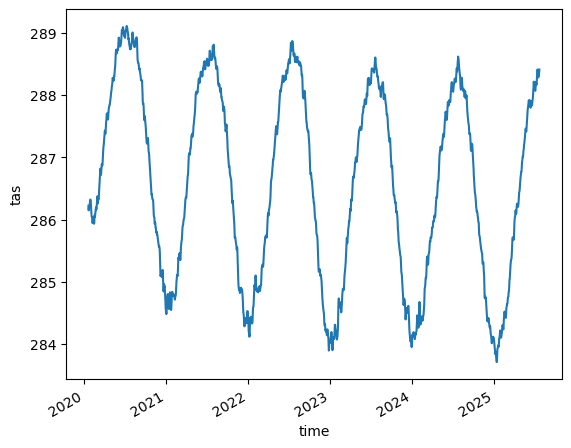

In [15]:
icon_5km_2t_daily_gm.plot()

In [16]:
icon_5km_2t_daily_gm

<xarray.DataArray 'tas' (time: 2010)>
array([286.2222 , 286.14792, 286.19235, ..., 288.32156, 288.37537,
       288.41122], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-21 2020-01-22 ... 2025-07-22

In [17]:
# compute monthly means from daily mean time series
icon_5km_2t_gm = cdo.monmean(input=icon_5km_2t_daily_gm.to_dataset(),returnXDataset=True).tas

In [18]:
# TOA radiation

#LW 
icon_5km_rlut_daily_gm = ds_icon.rlut.mean("cell")
icon_5km_rlut_gm = cdo.monmean(input=icon_5km_rlut_daily_gm.to_dataset(),returnXDataset=True).rlut

# SW
# incoming
icon_5km_rsdt_daily_gm = ds_icon.rsdt.mean("cell")
icon_5km_rsdt_gm = cdo.monmean(input=icon_5km_rsdt_daily_gm.to_dataset(),returnXDataset=True).rsdt

# outgoing
icon_5km_rsut_daily_gm = ds_icon.rsut.mean("cell")
icon_5km_rsut_gm = cdo.monmean(input=icon_5km_rsut_daily_gm.to_dataset(),returnXDataset=True).rsut


In [19]:
# create a dataset with the same conventions for direction as used in IFS and the CERES dataset loaded below
TOA_icon_5km_gm = (icon_5km_rlut_gm*-1).to_dataset().rename({'rlut':'ttr'})

# compute net solar
icon_5km_tsr_gm = icon_5km_rsdt_gm - icon_5km_rsut_gm
TOA_icon_5km_gm = TOA_icon_5km_gm.assign(tsr=icon_5km_tsr_gm)

# add net radiation
TOA_icon_5km_gm = TOA_icon_5km_gm.assign(tnr=TOA_icon_5km_gm.tsr+TOA_icon_5km_gm.ttr)



---

### Quick plots for some model output:

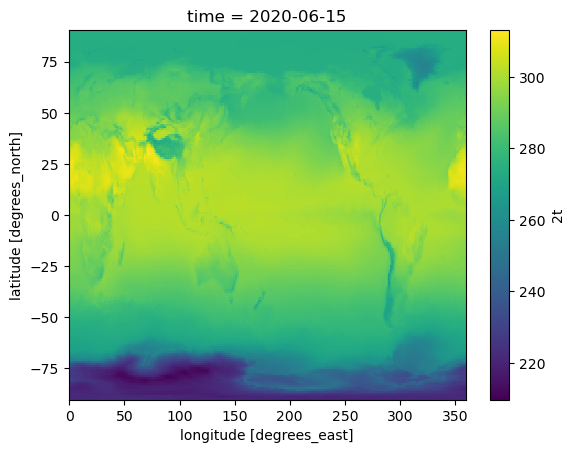

In [20]:
ifs_2t.sel(time='2020-06').plot()

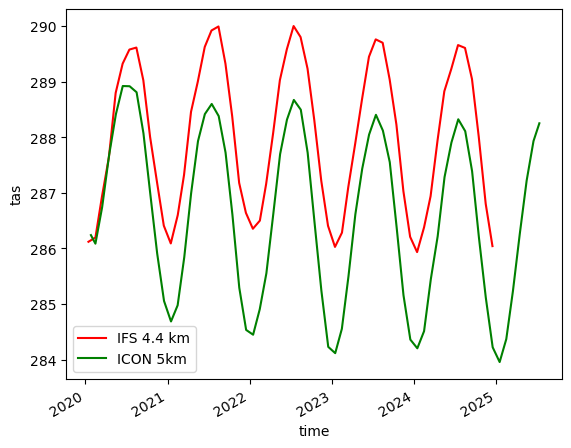

In [21]:
# compute global mean 2t and plot time series:
cdo.fldmean(input=ifs_2t.to_dataset(), returnXDataset=True)['2t'].plot(color='red',label='IFS 4.4 km')
icon_5km_2t_gm.plot(color='green',label='ICON 5km')

plt.legend()

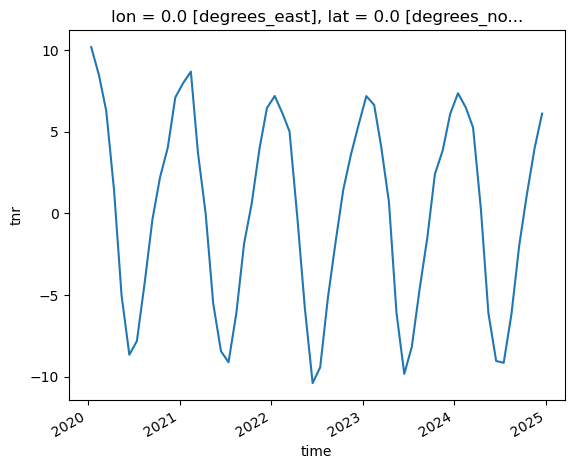

In [22]:
# net TOA radiation:
TOA_ifs_gm.tnr.plot()

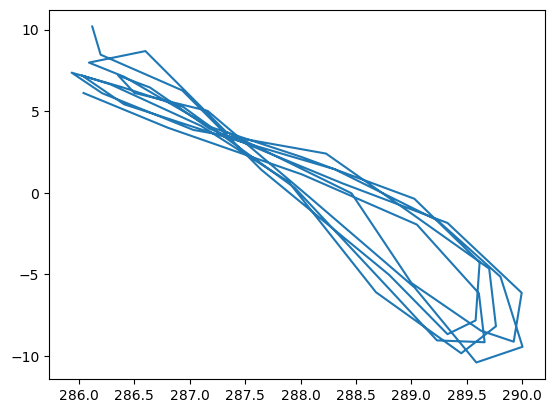

In [23]:
# gregory plot (more complete version later in this notebook):
plt.plot(cdo.fldmean(input=ifs_2t.to_dataset(), returnXDataset=True)['2t'].squeeze(),TOA_ifs_gm.tnr.squeeze())


---

## load reference datasets

### CERES
As a reference, we generally use the energy-balanced monthly mean CERES EBAF data.

In [24]:
# EBAF data
datdir = '/work/bb1153/m300265/NextGEMS/'+'observations/ceres-ebaf/'
ifile = datdir+'CERES_EBAF-TOA_Ed4.1_Subset_200003-202203_interpr360x180.nc'

ceres_ebaf = xr.open_dataset(ifile)

ceres_ebaf_ttr = ceres_ebaf.toa_lw_all_mon *-1
ceres_ebaf_tsr = ceres_ebaf.solar_mon - ceres_ebaf.toa_sw_all_mon
ceres_ebaf_tnr = ceres_ebaf.toa_net_all_mon

# write to Dataset with same variable names and definitions used by IFS
TOA_ceres_ebaf = ceres_ebaf_tsr.to_dataset(name='tsr')
TOA_ceres_ebaf = TOA_ceres_ebaf.assign(ttr=ceres_ebaf_ttr)
TOA_ceres_ebaf = TOA_ceres_ebaf.assign(tnr=ceres_ebaf_tnr)

# limit to years that are complete
TOA_ceres_ebaf = TOA_ceres_ebaf.sel(time=slice('2001','2021'))

In [25]:
# compute climatology
# note: setting time axis to the same time axis as model output
TOA_ceres_clim = TOA_ceres_ebaf.groupby('time.month').mean('time').rename({'month': 'time'}).assign_coords(time=TOA_ifs_gm.sel(time='2020').time).transpose("time", ...)
TOA_ceres_clim_gm = cdo.fldmean(input=TOA_ceres_clim, returnXDataset=True)

# global mean of monthly time series
TOA_ceres_ebaf_gm = cdo.fldmean(input=TOA_ceres_ebaf, returnXDataset=True) # needed for gregory plot

#### confidence interval for biases
Biases are calculated relative to the climatology. Confidence intervals are constructed from interannual variability in CERES by computing the difference from each year to the climatology.

In [26]:
samples_tmp = []

for year in range(2001,2021):
    # select year and assign (fake) time coordinates of 2020 so that the differencing works
    samples_tmp.append(TOA_ceres_ebaf.sel(time=str(year)).assign_coords(time=TOA_ceres_clim.time)-TOA_ceres_clim)

TOA_ceres_diff_samples = xr.concat(samples_tmp,dim='ensemble').transpose("time", ...)

TOA_ceres_diff_samples_gm = cdo.fldmean(input=TOA_ceres_diff_samples,returnXDataset=True).squeeze()



### ERA5
from file, not catalogue because monthly means are not available in catalog anymore?!

In [27]:
ifile = '/work/bb1153/m300265/NextGEMS/observations/ERA5_temp2_mm_2000-2022.nc'
ifile_gm = '/work/bb1153/m300265/NextGEMS/observations/ERA5_temp2_mm_2000-2022_gm.nc' # used cdo fldmean to compute area-weighted global mean

era5 = xr.open_dataset(ifile)['2t']
era5_gm = xr.open_dataset(ifile_gm)['2t']
# move time stamps to middle of the month (same convention used for model output)
era5['time'] = era5.time+np.timedelta64(15, 'D')
era5_gm['time'] = era5_gm.time+np.timedelta64(15, 'D')

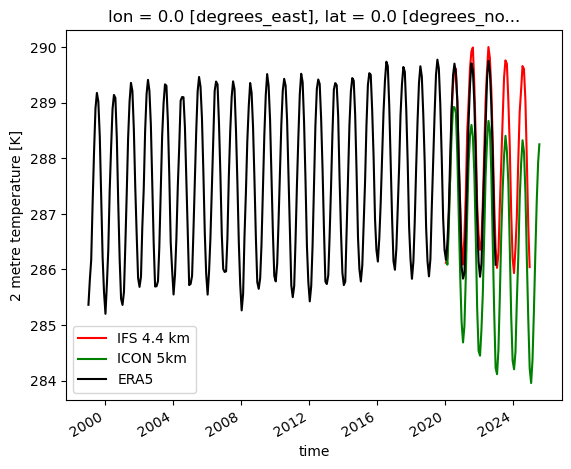

In [28]:
# quick plot, also adding some model simulations

# compute global mean 2t and plot time series:
cdo.fldmean(input=ifs_2t.to_dataset(), returnXDataset=True)['2t'].plot(color='red',label='IFS 4.4 km')
icon_5km_2t_gm.plot(color='green',label='ICON 5km')

era5_gm.plot(color='black',label='ERA5')
# plt.xlim([pd.to_datetime('2020-01-15'),pd.to_datetime('2024-12-15')]) # use this to limit x-axis to model simulations

plt.legend()

---
## plotting
### global mean time series

In [29]:
TOA_ifs_9km_gm.ttr.sel(time='2021')

<xarray.DataArray 'ttr' (time: 12, lat: 1, lon: 1)>
[12 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 2021-01-15 2021-02-15 ... 2021-12-15
  * lon      (lon) float64 0.0
  * lat      (lat) float64 0.0

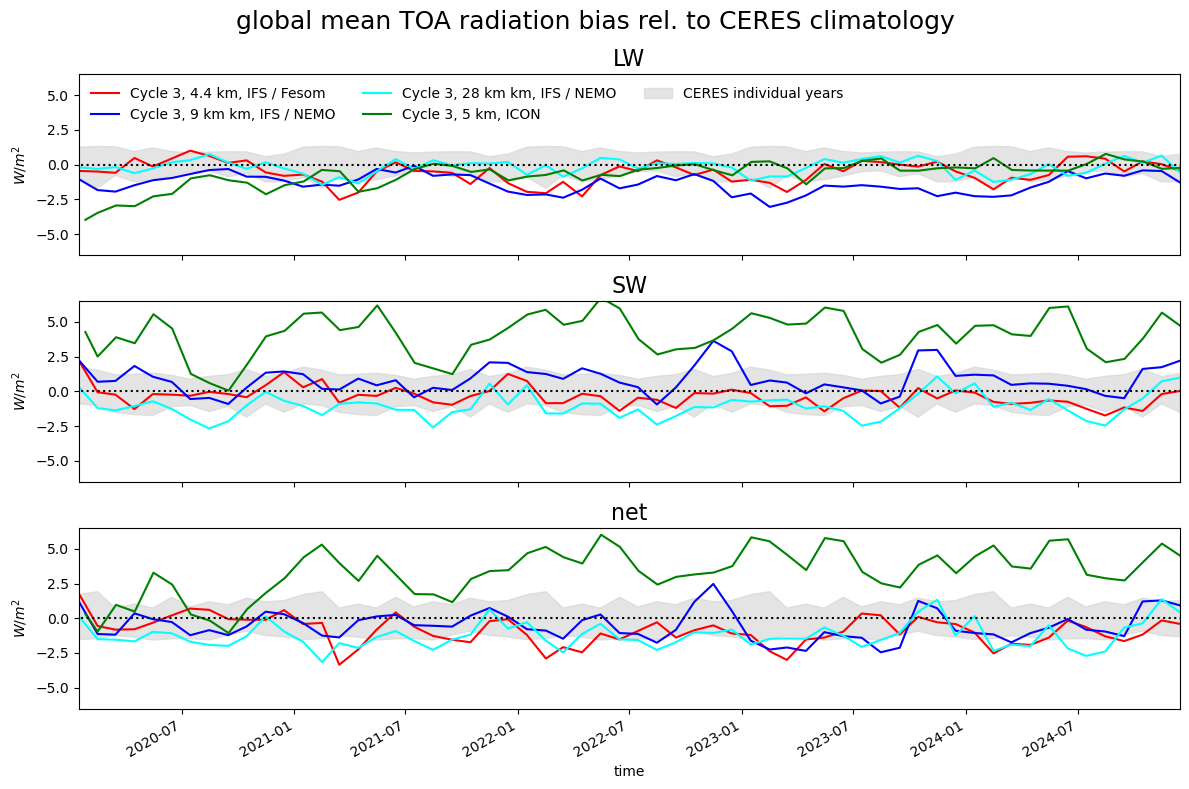

In [30]:
fig, axes = plt.subplots(3, 1,figsize=(12,8))
linecolors = ['red',
              'blue',
              'cyan',
              'green',
             ]
linelabels = ['Cycle 3, 4.4 km, IFS / Fesom',
              'Cycle 3, 9 km km, IFS / NEMO',
              'Cycle 3, 28 km km, IFS / NEMO',
              'Cycle 3, 5 km, ICON',
             ]
models = [TOA_ifs_gm.squeeze(),
          TOA_ifs_9km_gm.squeeze(),
          TOA_ifs_28km_gm.squeeze(),
          TOA_icon_5km_gm.squeeze(),
         ]


# duplicate CERES IV sampels and concatenate years to plot one connected envelope for IV uncertainty
shading_data = xr.concat((TOA_ceres_diff_samples_gm, 
                          TOA_ceres_diff_samples_gm.assign_coords(time=models[0].ttr.sel(time='2021').time),
                          TOA_ceres_diff_samples_gm.assign_coords(time=models[0].ttr.sel(time='2022').time),
                          TOA_ceres_diff_samples_gm.assign_coords(time=models[0].ttr.sel(time='2023').time),
                          TOA_ceres_diff_samples_gm.assign_coords(time=models[0].ttr.sel(time='2024').time),
                         ),dim='time' )
long_time=np.append(shading_data['time'],shading_data['time'][::-1])


# panel a

for i,model in enumerate(models):
    xr.concat(((model.ttr.sel(time='2020')-TOA_ceres_clim_gm.squeeze().ttr.values),
               (model.ttr.sel(time='2021')-TOA_ceres_clim_gm.squeeze().ttr.values),
               (model.ttr.sel(time='2022')-TOA_ceres_clim_gm.squeeze().ttr.values),
               (model.ttr.sel(time='2023')-TOA_ceres_clim_gm.squeeze().ttr.values),
               (model.ttr.sel(time='2024')-TOA_ceres_clim_gm.squeeze().ttr.values)),
              dim='time').plot(ax=axes[0],color=linecolors[i],label=linelabels[i],x='time')


axes[0].fill(long_time,np.append(shading_data['ttr'].min(dim='ensemble'),shading_data['ttr'].max(dim='ensemble')[::-1]),color='lightgrey',alpha=0.6,label='CERES individual years',zorder=0)


axes[0].set_title('LW',fontsize=16)
axes[0].set_xticklabels([])
axes[0].set_xlabel('')
axes[0].legend(loc="upper left",frameon=False,fontsize='medium',ncol=3)

# # # panel b
for i,model in enumerate(models):
    xr.concat(((model.tsr.sel(time='2020')-TOA_ceres_clim_gm.squeeze().tsr.values),
               (model.tsr.sel(time='2021')-TOA_ceres_clim_gm.squeeze().tsr.values),
               (model.tsr.sel(time='2022')-TOA_ceres_clim_gm.squeeze().tsr.values),
               (model.tsr.sel(time='2023')-TOA_ceres_clim_gm.squeeze().tsr.values),
               (model.tsr.sel(time='2024')-TOA_ceres_clim_gm.squeeze().tsr.values)),
              dim='time').plot(ax=axes[1],color=linecolors[i],label=linelabels[i],x='time')


axes[1].fill(long_time,np.append(shading_data['tsr'].min(dim='ensemble'),shading_data['tsr'].max(dim='ensemble')[::-1]),color='lightgrey',alpha=0.6,label='CERES individual years',zorder=0)

axes[1].set_title('SW',fontsize=16)
axes[1].set_xticklabels([])
axes[1].set_xlabel('')

# # # panel c
for i,model in enumerate(models):
    xr.concat(((model.tnr.sel(time='2020')-TOA_ceres_clim_gm.squeeze().tnr.values),
               (model.tnr.sel(time='2021')-TOA_ceres_clim_gm.squeeze().tnr.values),
               (model.tnr.sel(time='2022')-TOA_ceres_clim_gm.squeeze().tnr.values),
               (model.tnr.sel(time='2023')-TOA_ceres_clim_gm.squeeze().tnr.values),
               (model.tnr.sel(time='2024')-TOA_ceres_clim_gm.squeeze().tnr.values)),
              dim='time').plot(ax=axes[2],color=linecolors[i],label=linelabels[i],x='time')

axes[2].fill(long_time,np.append(shading_data['tnr'].min(dim='ensemble'),shading_data['tnr'].max(dim='ensemble')[::-1]),color='lightgrey',alpha=0.6,label='CERES individual years',zorder=0)
axes[2].set_title('net',fontsize=16)

for i in range(3):
    axes[i].set_ylabel('$W/m^2$')
    axes[i].set_xlim([pd.to_datetime('2020-01-15'),pd.to_datetime('2024-12-15')])
    axes[i].plot([pd.to_datetime('2020-01-01'),pd.to_datetime('2030-12-31')],[0,0],color='black',linestyle=':')
    axes[i].set_ylim([-6.5,6.5])


plt.suptitle('global mean TOA radiation bias rel. to CERES climatology',fontsize=18)
plt.tight_layout()    

plt.savefig(plotdir + 'TOA_bias_clim_global_mean_cycle3.png')

---
### maps
interpolate to the same grid to plot difference map. CERES has been interpolated to a regular 1x1 grid using cdo (r360x180). Use that same approach for model output.
(alternative: interpolate obs to model grid, not implemented)

In [31]:
TOA_ifs_r360x180 = cdo.remapcon('r360x180',input=TOA_ifs,returnXDataset=True)

In [32]:
TOA_ifs_r360x180

<xarray.Dataset>
Dimensions:  (time: 60, lon: 360, lat: 180)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-15 2020-02-15 ... 2024-12-15
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Data variables:
    ttr      (time, lat, lon) float64 ...
    tsr      (time, lat, lon) float64 ...
    tnr      (time, lat, lon) float64 ...
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu May 25 15:55:45 2023: cdo -O -s -f nc -remapcon,r360x18...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

In [33]:
# # quantiles are a bit more conservative than the range, but interpolation from few values might not be robust
# q05 = TOA_ceres_diff_samples.groupby('time.month').quantile(0.05,dim='ensemble')
# q95 = TOA_ceres_diff_samples.groupby('time.month').quantile(0.95,dim='ensemble')
# min-max range is more conservative, but could be sensitive to single extreme years
range_min = TOA_ceres_diff_samples.groupby('time.month').min(dim='ensemble')
range_max = TOA_ceres_diff_samples.groupby('time.month').max(dim='ensemble')

In [34]:
# stippled areas are biases that do not exceed interannual variability (i.e. probably not significant)

def plot_bias(data,iax,title,plotlevels,lower,upper,index):
    plot = data.plot(ax=iax,
              transform=ccrs.PlateCarree(),
              colors='RdBu_r',
              linewidths=0.3,
              levels=plotlevels,
              add_colorbar=False,
                     )
    stipple_data = data.where(np.logical_and(data>lower.isel(month=index), data<upper.isel(month=index)))/data.where(np.logical_and(data>lower.isel(month=index), data<upper.isel(month=index)))
    plot2 = stipple_data.plot.contourf(ax=iax,levels=[-10,0,10], hatches=["","...."],add_colorbar=False, alpha=0, transform=ccrs.PlateCarree())


    iax.set_title(title,fontsize=small_fonts)
    # iax.set_title(data.label+' ('+str(len(data.ensemble))+')',fontsize=small_fonts)

    return plot

def plot_maps(TOA_model, var, model_label,year='2020'):
    TOA_model = TOA_model.sel(time=year)
    if var=='tnr':
        label='net'
    elif var=='tsr':
        label='SW'
    elif var=='ttr':
        label='LW'
        
    if year == '2020':
        panel_1_off = True
    else:
        panel_1_off = False

    # what to use for significance testing
    # everything between these values will be considered not significant and hatched in the plot
    lower = range_min[var].rename({'time': 'month'})
    upper = range_max[var].rename({'time': 'month'})


    fig, ax = plt.subplots(3, 4,figsize=(24,10), subplot_kw={'projection': ccrs.Robinson(central_longitude=180, globe=None)})
    plotlevels=np.arange(-50,51,10)
    global small_fonts
    small_fonts = 8
    # plt.figure(figsize=(8,4))
    # axes = plt.axes(projection=ccrs.PlateCarree())
    axes = ax.flatten()


    for index in range( len(TOA_model.time) ): # some experiments have less than 12 months, draw fewer panels for those
            plot = plot_bias(TOA_model[var].sel(time=year).isel(time=index)-TOA_ceres_clim[var].isel(time=index)
                             ,iax=axes[index],title=calendar.month_name[index+1],plotlevels=plotlevels
                             ,lower=lower,upper=upper,index=index)

    for axi in axes:
        axi.coastlines(color='brown',linewidth=0.4)

    if panel_1_off:
        axes[0].remove()


    # plt.tight_layout()
    # common colorbar
    fig.subplots_adjust(right=0.95)
    cbar_ax = fig.add_axes([0.96, 0.3, 0.02, 0.4]) # [left, bottom, width, height]
    cbar = fig.colorbar(plot, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=small_fonts)
    cbar.set_label('$W m^{-2}$', labelpad=-32, y=-.08, rotation=0)

    plt.suptitle(label+' TOA bias IFS ' + model_label + ' ' + year + '\nrel. to CERES climatology (2001-2021)',fontsize=small_fonts*2)
    # plt.tight_layout()
    plt.savefig(plotdir+'1_'+label+'_TOA_bias_'+year+'_'+model_label+'.png',dpi=300)
    plt.show()

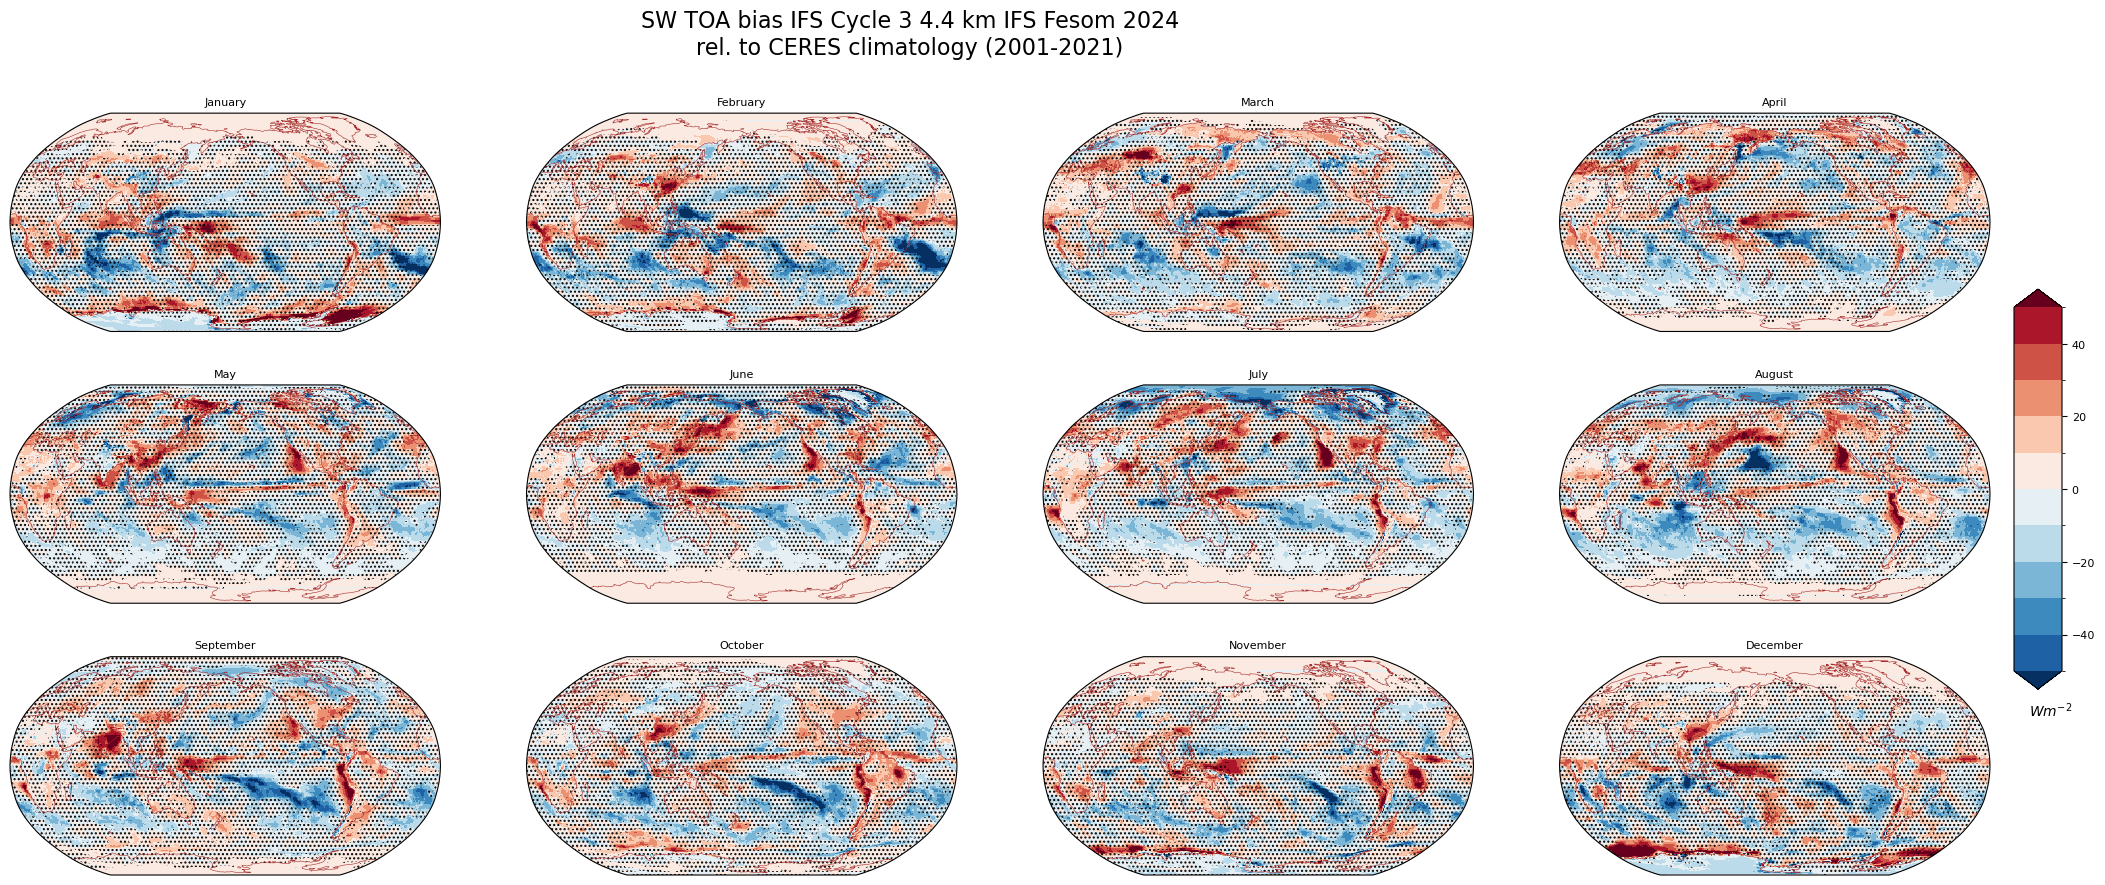

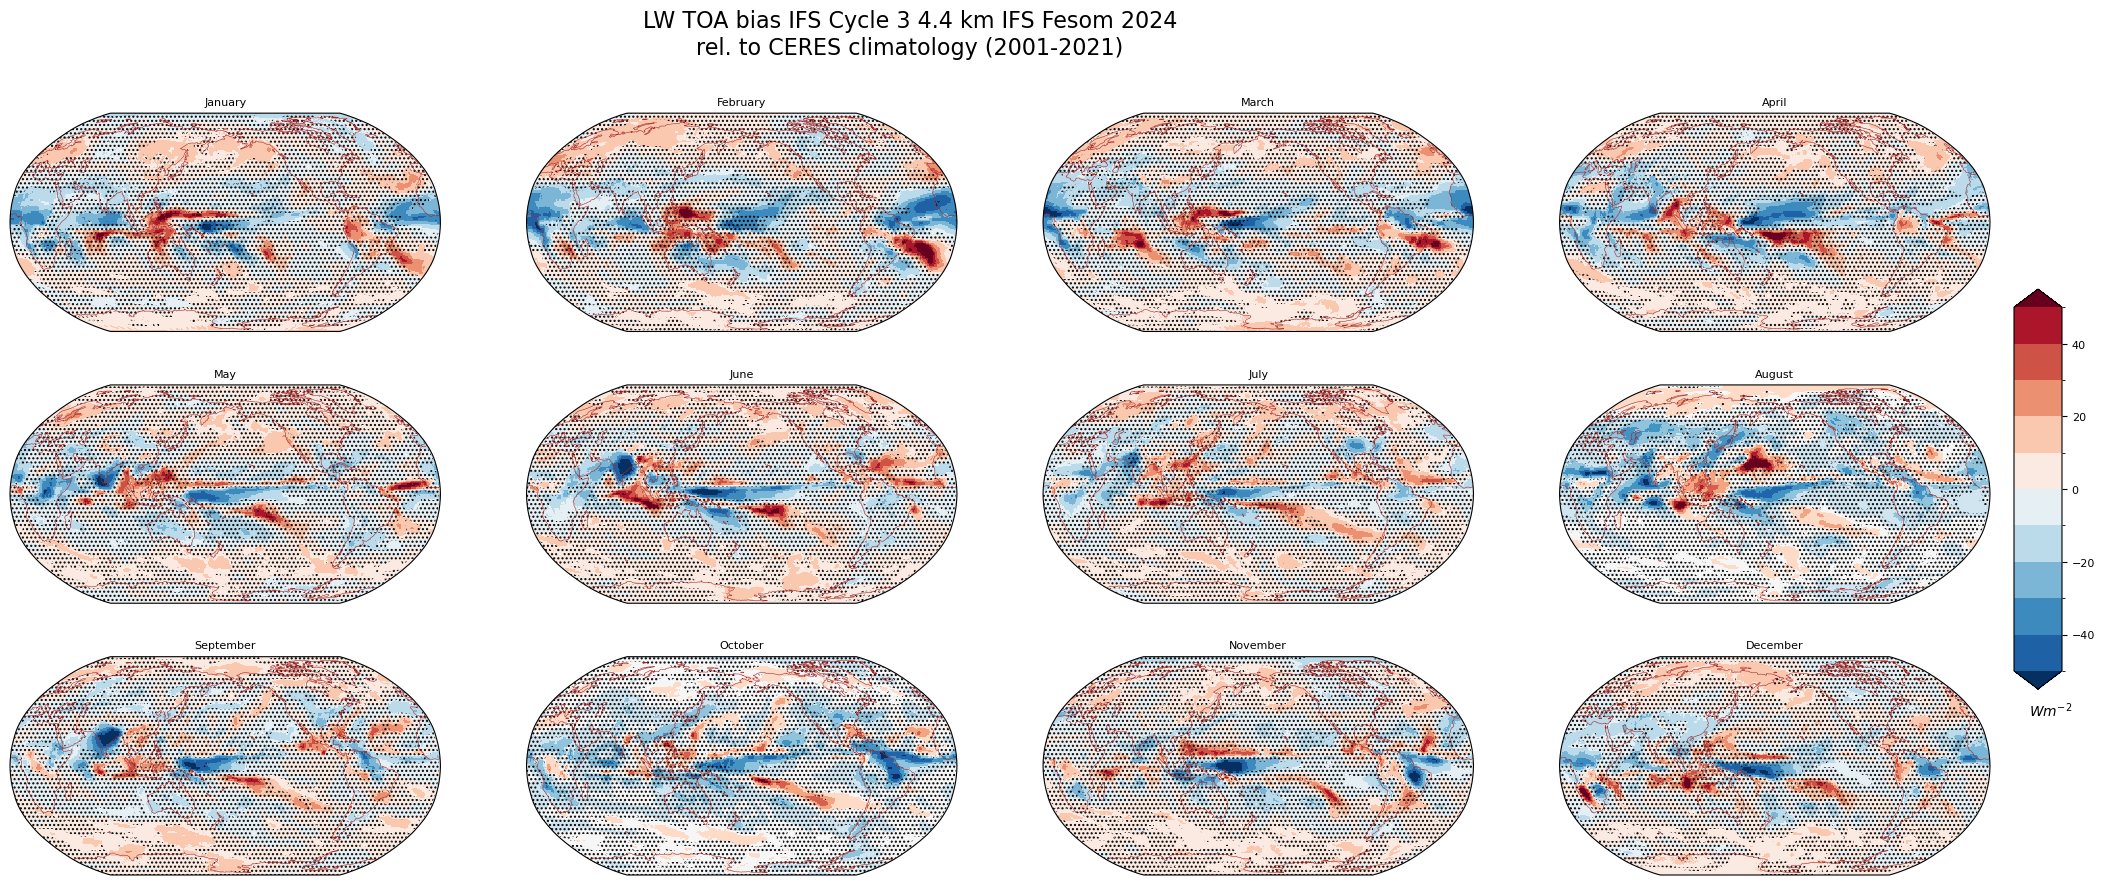

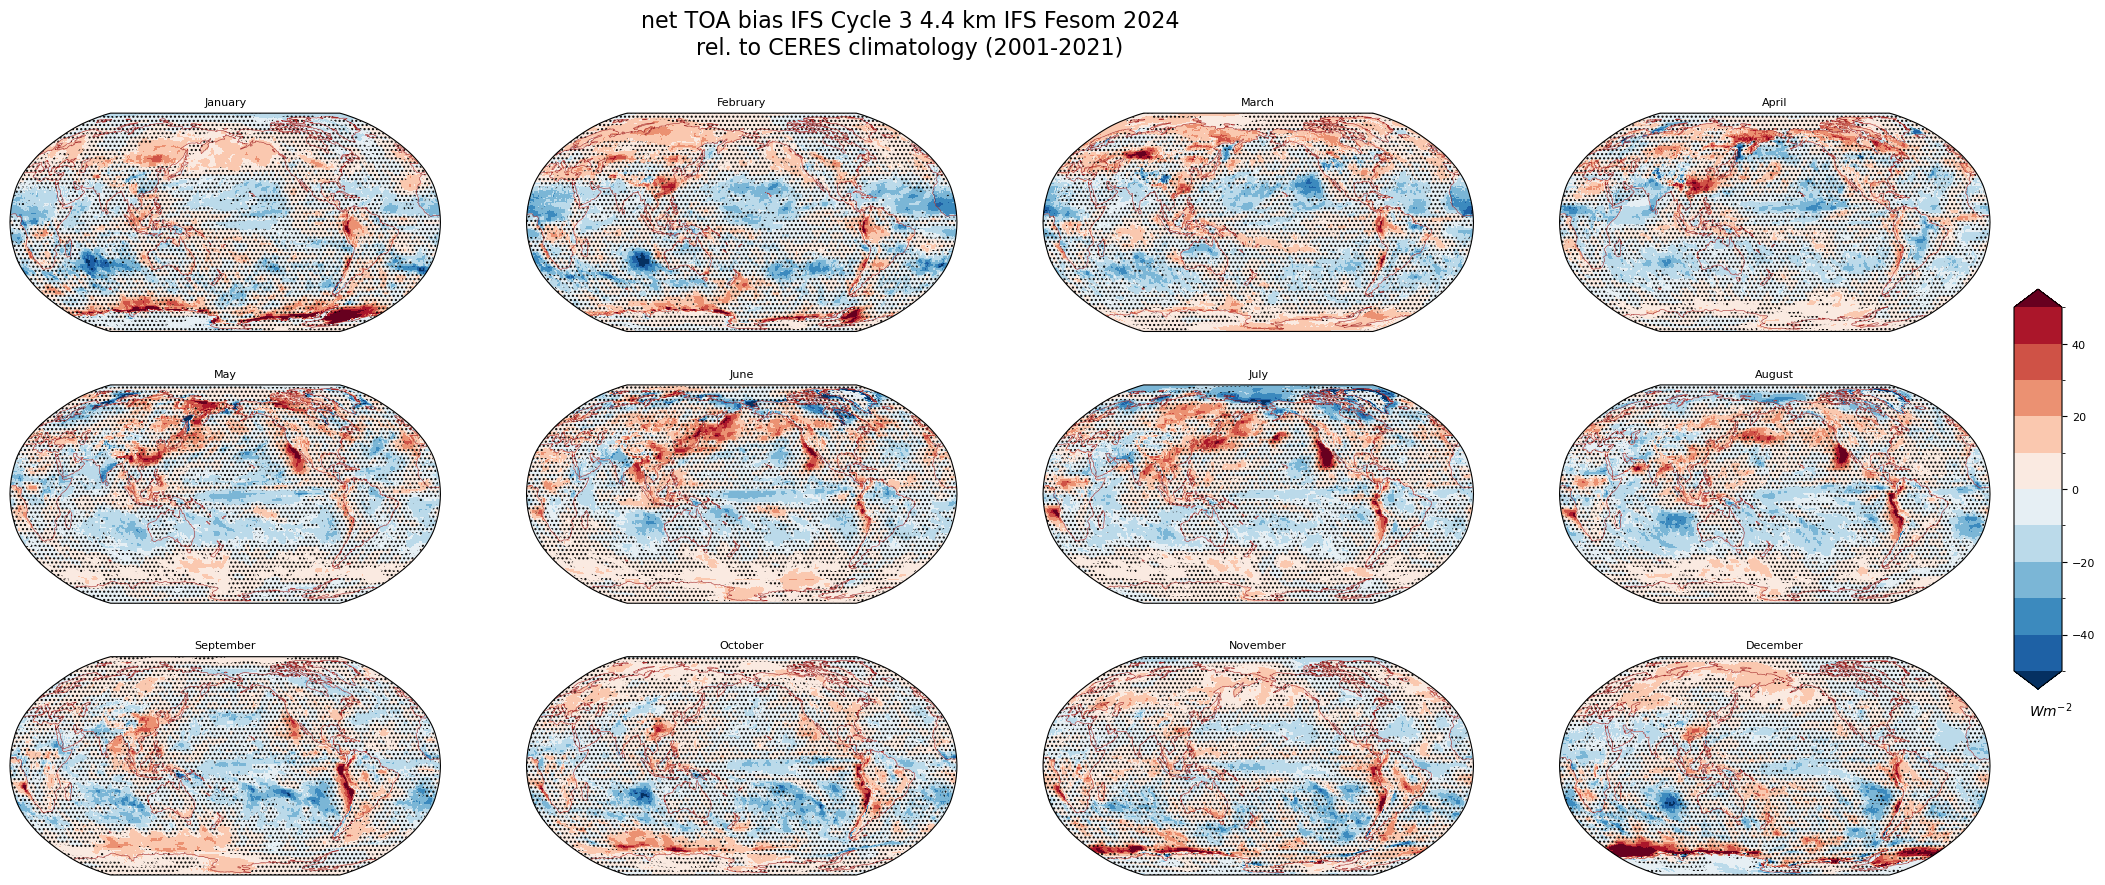

In [38]:
plot_maps(TOA_model=TOA_ifs_r360x180, var='tsr', model_label='Cycle 3 4.4 km IFS Fesom',year='2024') # note that model_label is also used in the filename, so avoid using characters that are not permitted for filenames
plot_maps(TOA_model=TOA_ifs_r360x180, var='ttr', model_label='Cycle 3 4.4 km IFS Fesom',year='2024')
plot_maps(TOA_model=TOA_ifs_r360x180, var='tnr', model_label='Cycle 3 4.4 km IFS Fesom',year='2024')

---

### Gregory plot
TOA net radiation imbalance (y-axis) vs global mean near-surface air temperature (GSAT) to compare imbalance and temperature to observations and analyse potential drift and equilibration

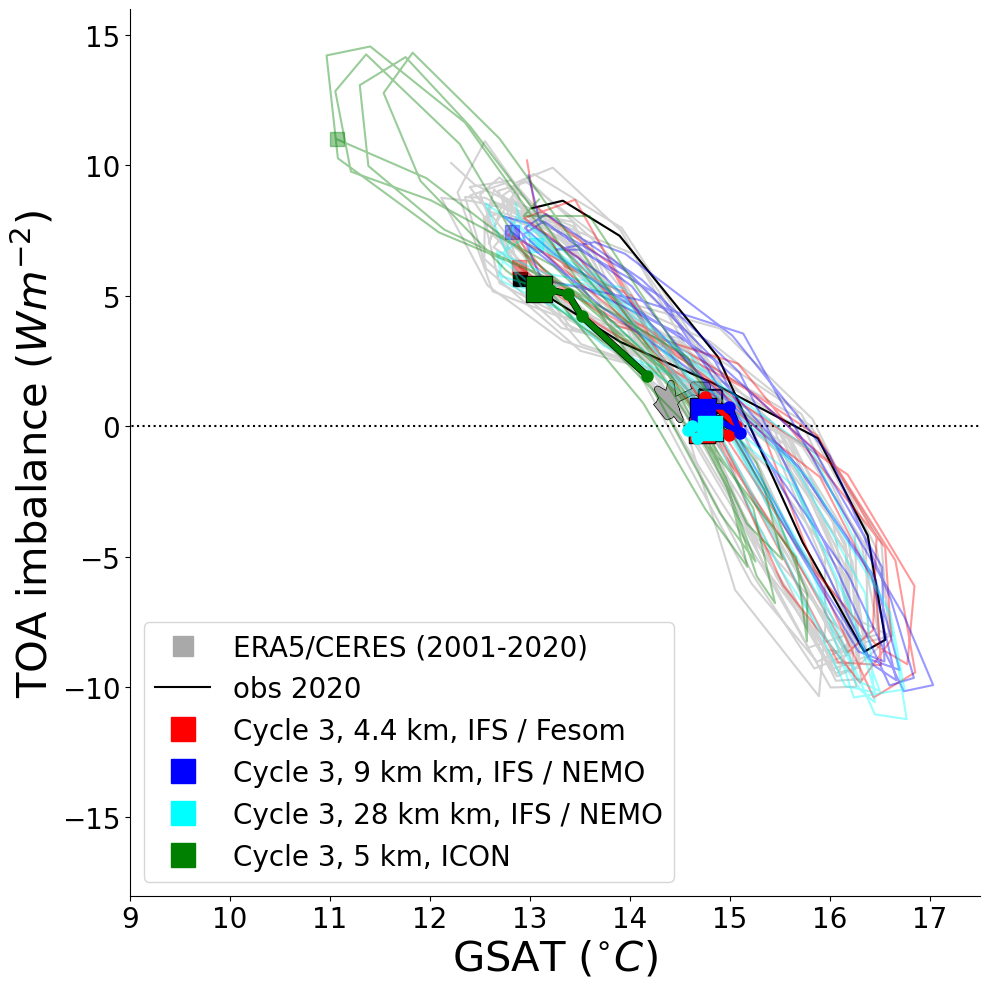

In [39]:
fig, ax = plt.subplots(figsize=(10,10))


linecolors = ['red',
              'blue',
              'cyan',
              'green',
             ]
linelabels = ['Cycle 3, 4.4 km, IFS / Fesom',
              'Cycle 3, 9 km km, IFS / NEMO',
              'Cycle 3, 28 km km, IFS / NEMO',
              'Cycle 3, 5 km, ICON',
             ]
models_toa = [TOA_ifs_gm.tnr.squeeze(),
              TOA_ifs_9km_gm.tnr.squeeze(),
              TOA_ifs_28km_gm.tnr.squeeze(),
              TOA_icon_5km_gm.sel(time=slice('2020','2024')).tnr.squeeze(), # selecting 2020-2024 because 2025 is incomplete and the annual mean can't be computed
             ]
models_temp = [cdo.fldmean(input=ifs_2t.to_dataset(), returnXDataset=True)['2t'].squeeze()-273.15,
               cdo.fldmean(input=ifs_9km_2t.to_dataset(), returnXDataset=True)['2t'].squeeze()-273.15,
               cdo.fldmean(input=ifs_28km_2t.to_dataset(), returnXDataset=True)['2t'].squeeze()-273.15,
               icon_5km_2t_gm.sel(time=slice('2020','2024'))-273.15,
              ]


small_fonts = 20
large_fonts = small_fonts*1.5
lw = 2

# obs
x=era5_gm.sel(time=slice('2001','2020')).squeeze()-273.15
y=TOA_ceres_ebaf_gm.tnr.sel(time=slice('2001','2020')).squeeze()
x_ym = x.groupby('time.year').mean(dim='time')
y_ym = y.groupby('time.year').mean(dim='time')
plt.plot(x,y,color='lightgrey',label='')
plt.plot(x_ym,y_ym,color='black',linewidth=5,label='')
plt.plot(x_ym,y_ym,color='darkgrey',linewidth=4,label='')
plt.plot(x_ym[-1],y_ym[-1],'s',markersize=17,color='black')
plt.plot(x_ym[-1],y_ym[-1],'s',markersize=15,color='darkgrey',label='ERA5/CERES (2001-2020)')
plt.plot(x[-1],y[-1],'s',markersize=10,color='lightgrey')

# obs 2020
x=era5_gm.sel(time='2020').squeeze()-273.15
y=TOA_ceres_ebaf_gm.tnr.sel(time='2020').squeeze()
x_ym = x.groupby('time.year').mean(dim='time')
y_ym = y.groupby('time.year').mean(dim='time')
plt.plot(x,y,color='black',label='obs 2020')
plt.plot(x[-1],y[-1],'s',markersize=10,color='black')


# plot all models from list:

for i,model in enumerate(models_toa):
    x=models_temp[i]
    y=models_toa[i]
    x_ym = x.groupby('time.year').mean(dim='time')
    y_ym = y.groupby('time.year').mean(dim='time')
    plt.plot(x,y,color=linecolors[i],label='',zorder=20, alpha=0.4) # thin line for monthly means
    plt.plot(x[-1],y[-1],'s',markersize=10,color=linecolors[i], alpha=0.4) # small square marking last monthly mean in simulation
    plt.plot(x_ym,y_ym,color='black',linewidth=5,label='',zorder=40) # solid line for annual means (black border)
    plt.plot(x_ym,y_ym,color=linecolors[i],linewidth=4,label='',zorder=41) # solid line for annual means
    plt.plot(x_ym,y_ym,'.',color=linecolors[i],markersize=16,label='',zorder=41) # dots for each annual mean
    plt.plot(x_ym[-1],y_ym[-1],'s',markersize=19,color='black',zorder=40) # large square for annual mean of the final year (black border)
    plt.plot(x_ym[-1],y_ym[-1],'s',markersize=17,color=linecolors[i],zorder=41,label=linelabels[i]) # large square for annual mean of the final year
    

    


plt.tick_params(axis='x', labelsize=small_fonts )
plt.tick_params(axis='y', labelsize=small_fonts )

plt.plot([0,18],[0,0],color='black',linestyle=':')
plt.ylabel('TOA imbalance ($Wm^{-2}$)',fontsize=large_fonts )

plt.xlabel('GSAT ($^{\circ}C$)',fontsize=large_fonts )

plt.legend(fontsize=small_fonts,loc='lower left')

# Hide the right and top spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

plt.xlim([9,17.5])
plt.ylim([-18,16])
plt.tight_layout()
plt.savefig(plotdir+'gregory_plot.png',dpi=500)